In [1]:
# Add path
import os
import sys
project_root = os.path.dirname(os.path.dirname(os.path.abspath('')))  # similar-expressions/
sys.path.insert(0, project_root)

# Reload modules
from importlib import reload
from src.model import encoder, decoder
from src.utils import dataset, config, dev, dataset_dev, parsing, grammar
reload(decoder); reload(encoder); reload(dataset); reload(config); reload(dev); reload(dataset_dev); reload(parsing); reload(grammar); reload(grammar);

/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [3]:
import torch
import numpy as np
import sympy as sp
import pandas as pd
from matplotlib import pyplot as plt
from omegaconf import OmegaConf

from src.utils.dataset_dev import load_wandb_model, dataloader_from_wandb_cfg, data_from_loader
from src.utils.dataset import create_value_transform
from src.utils.dev import plot_var_distributions, plot_latent_distribution

# Load model and dataset
model, cfg = load_wandb_model(run='e51hcsb9', name='epoch=57.ckpt', project='simexp-03', replace=True, fallback_cfg_path='../train/config.yaml')
train_loader, test_loader, info = dataloader_from_wandb_cfg(cfg, max_length=int(1e6), allow_different_dataset_hash=True)
val_x, syntax_cats, value_transform = info['val_x'], info['syntax_cats'], info['value_transform']

/mhome/damtp/q/lc865/workspace/similar-expressions/src/utils/dataset_dev.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_fname, map_locati

dict_keys(['encoder.mlp.net.0.weight', 'encoder.mlp.net.0.bias', 'encoder.mlp.net.2.weight', 'encoder.mlp.net.2.bias', 'encoder.mlp.net.2.running_mean', 'encoder.mlp.net.2.running_var', 'encoder.mlp.net.2.num_batches_tracked', 'encoder.mlp.net.3.block.0.weight', 'encoder.mlp.net.3.block.0.bias', 'encoder.mlp.net.3.block.2.weight', 'encoder.mlp.net.3.block.2.bias', 'encoder.mlp.net.3.block.2.running_mean', 'encoder.mlp.net.3.block.2.running_var', 'encoder.mlp.net.3.block.2.num_batches_tracked', 'encoder.mlp.net.3.block.3.weight', 'encoder.mlp.net.3.block.3.bias', 'encoder.mlp.net.3.block.5.weight', 'encoder.mlp.net.3.block.5.bias', 'encoder.mlp.net.3.block.5.running_mean', 'encoder.mlp.net.3.block.5.running_var', 'encoder.mlp.net.3.block.5.num_batches_tracked', 'encoder.mlp.net.4.block.0.weight', 'encoder.mlp.net.4.block.0.bias', 'encoder.mlp.net.4.block.2.weight', 'encoder.mlp.net.4.block.2.bias', 'encoder.mlp.net.4.block.2.running_mean', 'encoder.mlp.net.4.block.2.running_var', 'encod

In [7]:
value_transform = create_value_transform(OmegaConf.create({'mapping': 'arcsinh', 'bias': None, 'scale': None}), None)

## Latent space distribution (+ samples for later use)

In [5]:
def encode_and_sample_dataset(model, data_loader, cfg, batch_size=2**15, max_data_len=None, calc_var_stats=False):
    if max_data_len is not None:
        assert batch_size <= max_data_len, 'Batch size must be less than max_data_len'
        num_samples = min(len(data_loader.dataset), max_data_len)
    else:
        num_samples = len(data_loader.dataset)

    print(f'Number of samples: {len(data_loader.dataset)} (dataloader), {num_samples} (encoded)')
    z_size = cfg.model.z_size
    
    mu = np.empty([num_samples, z_size])
    z = np.empty([num_samples, z_size])

    if calc_var_stats:
        mean_of_var = np.empty(num_samples)
        std_of_var = np.empty(num_samples)
    else:
        mean_of_var, std_of_var = None, None
    
    for i, x in enumerate(data_from_loader(data_loader, 'x', batch_size=batch_size, max_length=max_data_len)):
        mean, ln_var = model.encoder(x)
        
        start_idx, end_idx = i * batch_size, (i + 1) * batch_size

        mu[start_idx:end_idx, :] = mean.detach().numpy()
        z[start_idx:end_idx, :] = model.sample(mean, ln_var).detach().numpy()

        if calc_var_stats:
            var = ln_var.exp() * cfg.training.sampling.eps**2  # Effective var
            mean_of_var[start_idx:end_idx] = var.mean(dim=1).detach().numpy()
            std_of_var[start_idx:end_idx] = var.std(dim=1).detach().numpy()
    
    return mu, z, mean_of_var, std_of_var

mu_train, z_train, mean_of_var_train, std_of_var_train = encode_and_sample_dataset(model, train_loader, cfg, calc_var_stats=False, max_data_len=2**16)
mu_test, z_test, mean_of_var_test, std_of_var_test = encode_and_sample_dataset(model, test_loader, cfg, calc_var_stats=False, max_data_len=2**16)

Number of samples: 900000 (dataloader), 65536 (encoded)
Number of samples: 100000 (dataloader), 65536 (encoded)


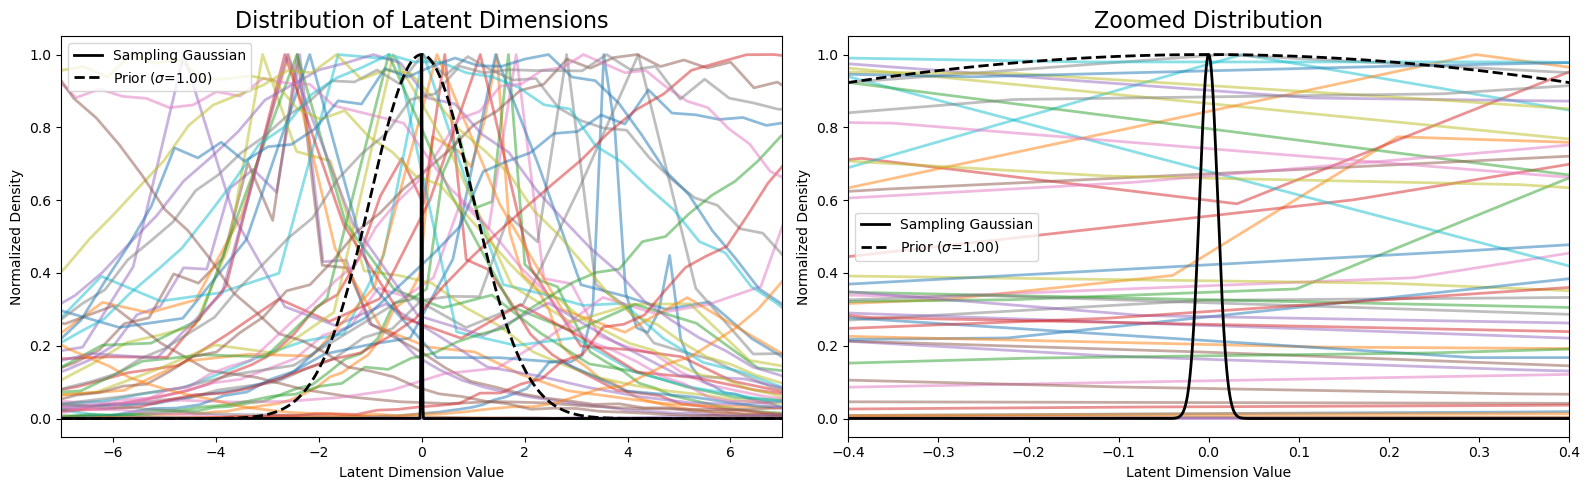

In [20]:
# plot_var_distributions(mean_of_var_train, mean_of_var_test, std_of_var_train, std_of_var_test)
plot_latent_distribution(mu_train, cfg)

## General latent vector stats

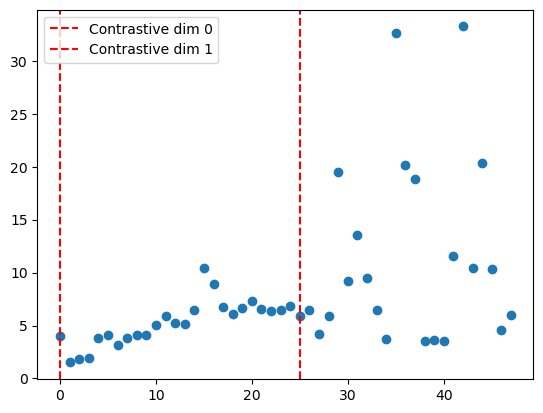

In [28]:
mean_magn = np.abs(z_train).mean(axis=0)
plt.scatter(range(len(mean_magn)), mean_magn)
# Add vertical lines at contrastive dimensions
plt.axvline(x=cfg.training.loss.contrastive.dimensions[0], color='r', linestyle='--', label='Contrastive dim 0')
plt.axvline(x=cfg.training.loss.contrastive.dimensions[1], color='r', linestyle='--', label='Contrastive dim 1') 
plt.legend()


## Examine neighbourhood in latent space of training samples 

Encode into latent space, sample from neighbourhood, decode expression and evaluate it.

In [51]:
from omegaconf import OmegaConf
value_transform = create_value_transform(OmegaConf.create({'mapping': 'arcsinh', 'bias': None, 'scale': None}), None)

In [30]:
reload(dev)

<module 'src.utils.dev' from '/mhome/damtp/q/lc865/workspace/similar-expressions/src/utils/dev.py'>

100%|██████████| 100/100 [00:00<00:00, 231.63it/s]


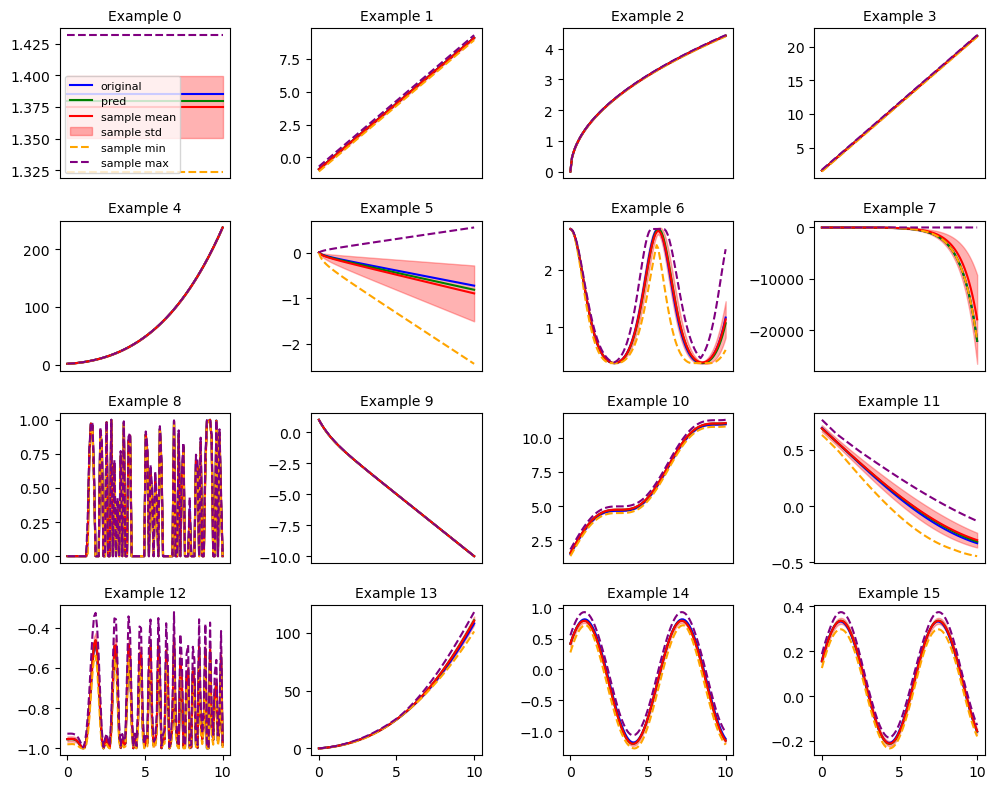

In [32]:
# Sampling with decoder -> eval
from src.utils.dev import calc_and_plot_samples_grid

model.sampling_eps = 1e-1

start_idx = 0
idx = range(start_idx, start_idx+16)
n_samples = 100

data_loader = train_loader
x = data_from_loader(data_loader, 'x', idx=idx)
values_true = data_from_loader(data_loader, 'values', idx=idx)

calc_and_plot_samples_grid(model, x, values_true, n_samples, idx, mode='syntax', val_x=val_x, value_transform=value_transform, var_multiplier=10, use_const_var=False)

## Mean distance

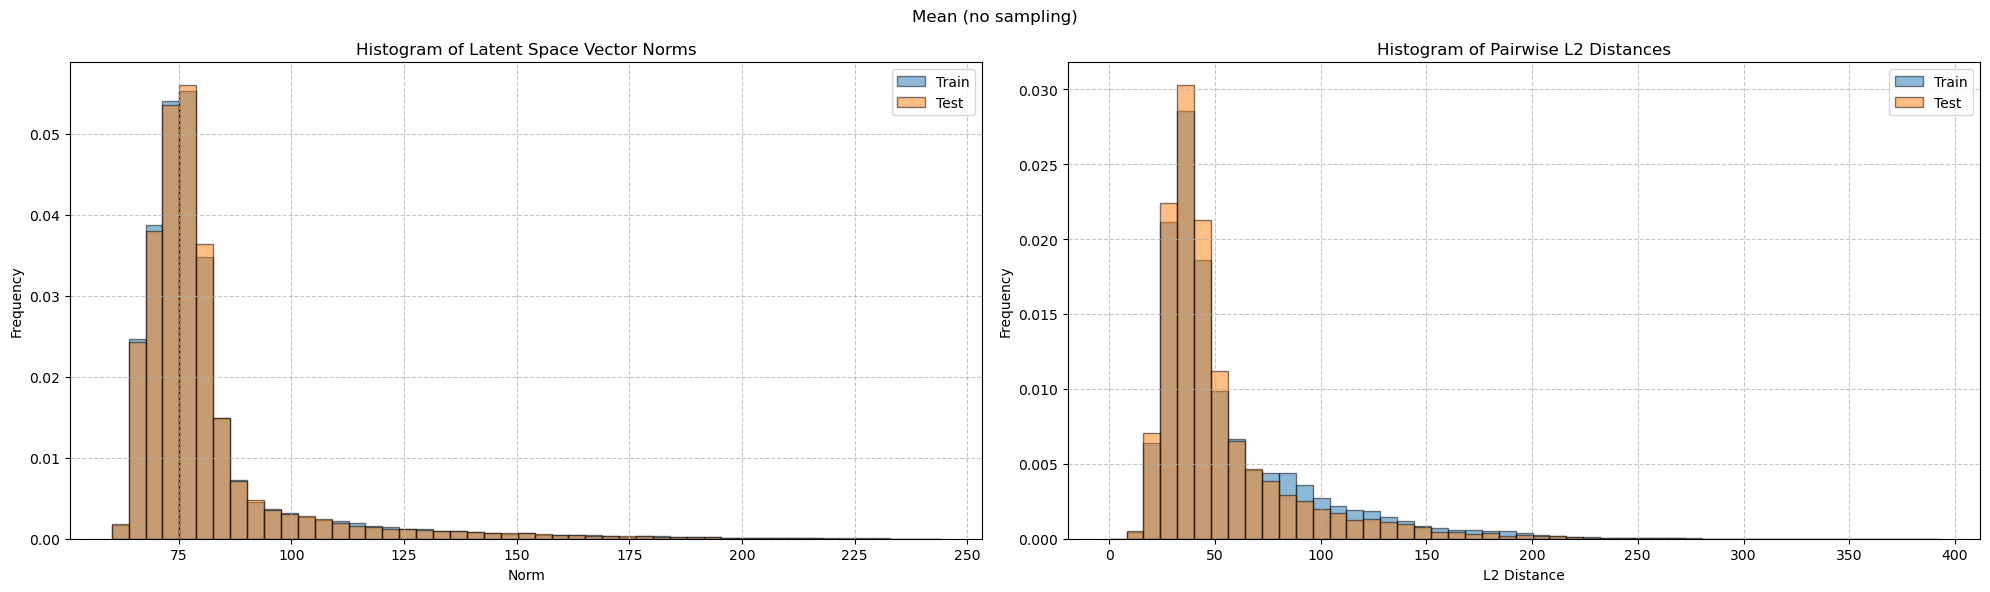

In [ ]:
from src.utils.dev import plot_latent_distances

plot_latent_distances(mu_train, mu_test, 'Mean (no sampling)')

## Interpolation study

Distance: 1.57566310992306


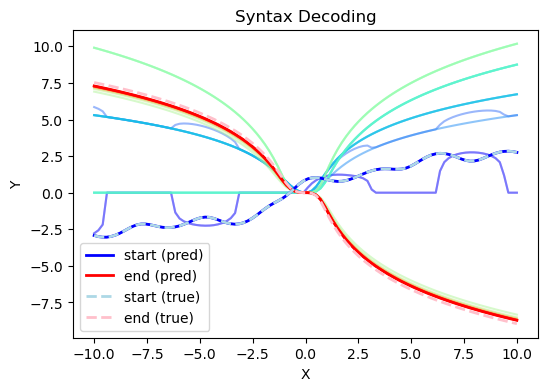

In [16]:
from src.utils.dev import plot_value_interpolation, slerp
from src.utils.parsing import logits_to_infix, eval_from_logits

# Parameters
i, j = 1, 2
num_steps = 30
interp_mode = 'slerp'

# Get data
z_start, z_end = mu_train[i], mu_train[j]
start_true = data_from_loader(train_loader, 'values', idx=i).squeeze().detach().numpy()
end_true = data_from_loader(train_loader, 'values', idx=j).squeeze().detach().numpy()


print(f'Distance: {np.linalg.norm(z_end - z_start)}')

# Interpolate in latent space
alpha = np.linspace(0, 1, num_steps)
if interp_mode == 'slerp':
    z_interp = slerp(z_start, z_end, alpha)
elif interp_mode == 'linear':
    z_interp = z_start[np.newaxis, ...] * (1 - alpha[:, np.newaxis]) + z_end[np.newaxis, ...] * alpha[:, np.newaxis]
else:
    raise ValueError(f'Interpolation mode {interp_mode} not supported')

# Decode into values and logits
logits_interp = model.decoder(torch.tensor(z_interp.astype(np.float32)))
    
values_interp = torch.empty(size=(logits_interp.shape[0], val_x.shape[0]))
for idx in range(0, logits_interp.shape[0]):
    try:
        res = eval_from_logits(logits_interp[idx, ...], val_x.squeeze())
        res = res.astype(np.float32)
        values_interp[idx, ...] = value_transform(torch.tensor(res).unsqueeze(0)).squeeze()
    except (TypeError, AssertionError):
        print(f'Warning: Failed to decode logits {idx}')
        values_interp[idx, ...] = torch.zeros(val_x.shape[0], dtype=torch.float32)


fig, ax1 = plt.subplots(figsize=(6, 4))
plot_value_interpolation(ax1, val_x, values_interp, start_true, end_true, 'Syntax Decoding')

## Property prediction (SNIP-inspired)

In [17]:
from src.utils.dev import calc_properties, plot_tsne_properties, plot_property_distributions, plot_original_vs_predicted_properties, plot_values_with_property
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt     

BATCH_SIZE = 2**15

properties = np.empty((len(train_loader.dataset), 4))
for i, x in enumerate(data_from_loader(train_loader, 'values', batch_size=BATCH_SIZE)):
    mean, upwardness, oscillations, non_convexity_ratio = calc_properties(x)
    oscillations = np.log(oscillations + 1)
    properties[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :] = np.array([mean, upwardness, oscillations, non_convexity_ratio]).T

/tmp/ipykernel_1210375/4089937549.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  oscillations = np.log(oscillations + 1)


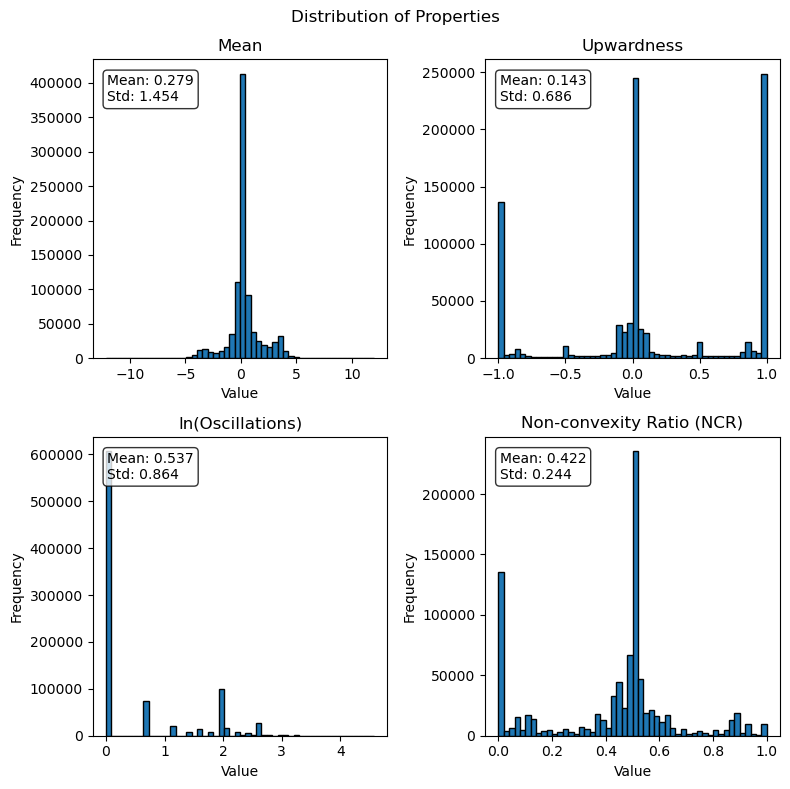

In [18]:
plot_property_distributions(properties)

In [19]:
n = 10000  # Number of samples to plot (tsne is slow!)
pca = PCA(n_components=6)
mu_train_pca = pca.fit_transform(mu_train[:n])
mu_train_2d = TSNE(n_components=2, random_state=42).fit_transform(mu_train_pca)

print(f"Cumulative explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

Cumulative explained variance ratio: 0.6979


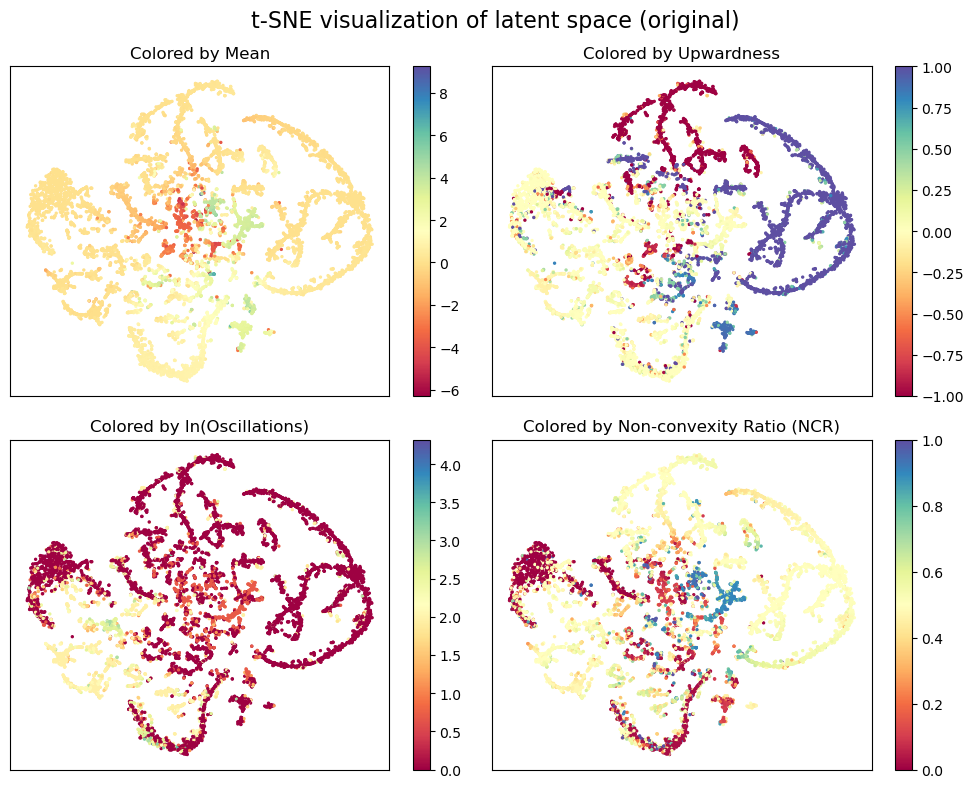

In [20]:
plot_tsne_properties(mu_train_2d, properties[:n], title='t-SNE visualization of latent space (original)')

In [57]:
values_pred = model.value_decoder(torch.tensor(mu_train[:n]).float())
mean, upwardness, oscillations, non_convexity_ratio = calc_properties(values_pred)
properties_pred = np.array([mean, upwardness, torch.log(1+oscillations), non_convexity_ratio]).T

plot_tsne_properties(mu_train_2d, properties_pred[:n], title='t-SNE visualization of latent space (predicted)')

TypeError: 'NoneType' object is not callable

In [58]:
plot_original_vs_predicted_properties(properties[:n], properties_pred)

NameError: name 'properties_pred' is not defined

#### Properties on example

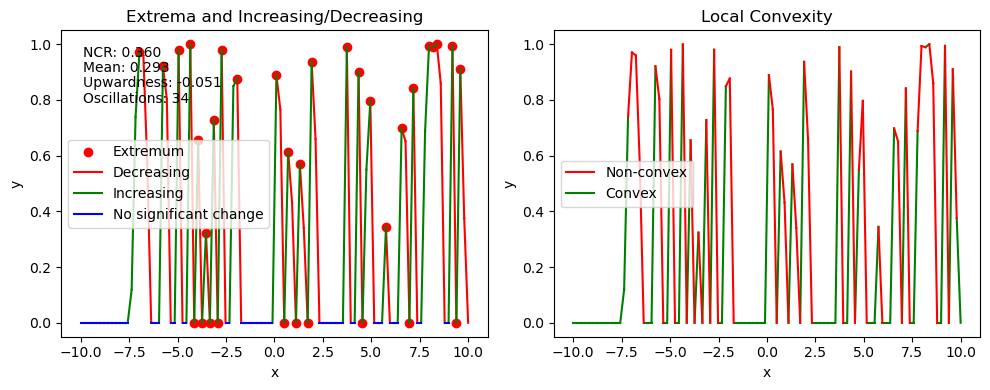

In [67]:
i = 8
y_values = data_from_loader(train_loader, 'values', idx=i)
plot_values_with_property(y_values)